$
\huge{
\textbf{
BaSTI Isochrones Only Notebook
}
}
$

In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [12]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [370]:
#create .dat files for the BaSTI isochrones along with monarch and astropy table
files = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.isc_2mass')

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1])

for j in range(len(files)):
    tab = readbasti(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)
        
#create rgb only table
#rgb branch 489 to 1289 in each isochrone

out_rgb  = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat'
for i, fname in enumerate(datfiles):
    df2 = pd.read_csv(fname,names=nom)
    df2 = df2[489:1289]
    df2.to_csv(out_rgb, mode = 'a+', index= False, header = False)

In [371]:
#Read in All dat file
basti = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat')
tbasti = Table.from_pandas(basti)

#Read in RGB dat file
nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']
rgbdat = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat',names=nom)
trgb = Table.from_pandas(rgbdat)
tempcut = np.where(trgb['LOGT']<=3.75)
trgb = trgb[tempcut]

In [363]:
print(trgb)

       MINI               MFIN        ...       LOGAGE             LOGG       
------------------ ------------------ ... ----------------- ------------------
       0.868633497 0.8658566490999999 ... 9.949975177829652 3.3852408906744422
      0.8687305601       0.8659411764 ... 9.949975177829652 3.3764132856231472
      0.8687502897 0.8659582106999999 ... 9.949975177829652     3.374571828732
      0.8687700194       0.8659755589 ... 9.949975177829652 3.3727405290964865
      0.8687897491       0.8659924294 ... 9.949975177829652  3.370918989720592
      0.8688094787       0.8660097647 ... 9.949975177829652 3.3690976832720905
      0.8688292084       0.8660268273 ... 9.949975177829652 3.3672462398961938
       0.868848938       0.8660439773 ... 9.949975177829652 3.3654448401801376
0.8688686676999999 0.8660607751999999 ... 9.949975177829652 3.3635832637298866
0.8688883973999999       0.8660781966 ... 9.949975177829652 3.3617619997701365
               ...                ... ...           

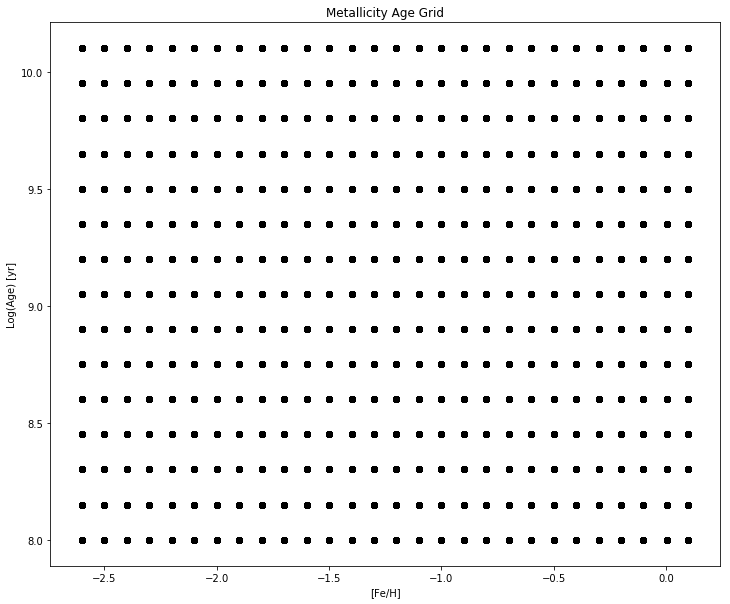

In [67]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(basti['FEH'],basti['LOGAGE'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('BaSTIgrid.pdf',bbox_inches='tight')
plt.show()

In [6]:
##########################
### Log(g) Calculation ###
##########################

'''Inserted into readbasti function'''

# mas = tbasti['MFIN']*(1.99*10**33) #mass in g
# tem = 10**tbasti['LOGT'] #T in K
# lum = (10**tbasti['LOGL'])*(3.9*10**33) #L in erg/s

# logg = np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum))

'Inserted into readbasti function'

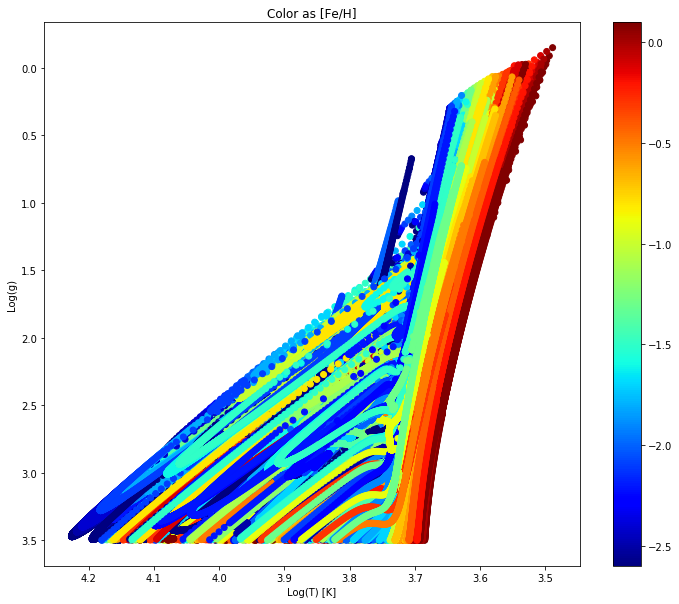

In [34]:
rgb = np.where(tbasti['LOGG']<3.5)

plt.figure(figsize=[12,10])
plt.scatter(tbasti['LOGT'][rgb],tbasti['LOGG'][rgb],c=tbasti['FEH'][rgb],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()

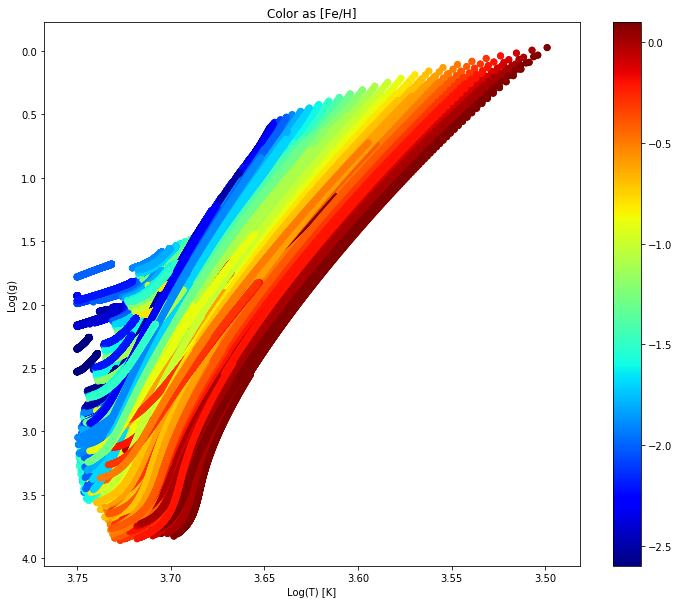

In [372]:
plt.figure(figsize=[12,10])
plt.scatter(trgb['LOGT'],trgb['LOGG'],c=trgb['FEH'],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()

In [274]:
# set(tbasti[rgb]['LOGAGE'])
# #set(tbasti[rgb]['FEH'])
# #4.10-3.32

{8.0,
 8.14921911265538,
 8.301029995663981,
 8.450249108319362,
 8.599883072073688,
 8.749736315569061,
 8.899820502427096,
 9.049992856920145,
 9.199755177253476,
 9.350441856535063,
 9.499961865596193,
 9.650015952471838,
 9.799960527405984,
 9.949975177829652,
 10.099991233544683}

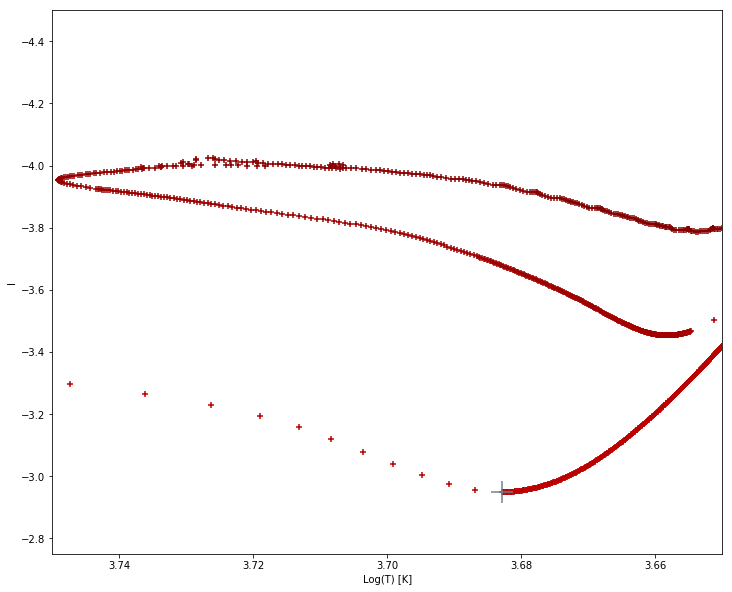

In [358]:
# rgbage = np.where((tbasti['FEH']==0.099)&(tbasti['LOGAGE']==8.0))

# #TRGB idx = 1289

# idx= 489

# Imag = 4.10-2.5*np.copy(tbasti['LOGL']) #4.10 is the I for the sun
# # mag[rgbage]

# plt.figure(figsize=[12,10])
# plt.scatter(tbasti['LOGT'][rgbage],Imag[rgbage],c=tbasti['MFIN'][rgbage]*(1.99*10**33),cmap='jet',marker='+')
# plt.scatter(tbasti[rgbage]['LOGT'][idx],Imag[rgbage][idx],marker='+',c='slategrey',s=500)
# plt.xlim(3.65,3.75)
# plt.ylim(-4.5,-2.75)
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# #plt.colorbar()
# plt.xlabel(r'Log(T) [K]')
# plt.ylabel(r'I')
# #plt.title(r'Color as [Fe/H]')
# plt.show()

(array([488]),)


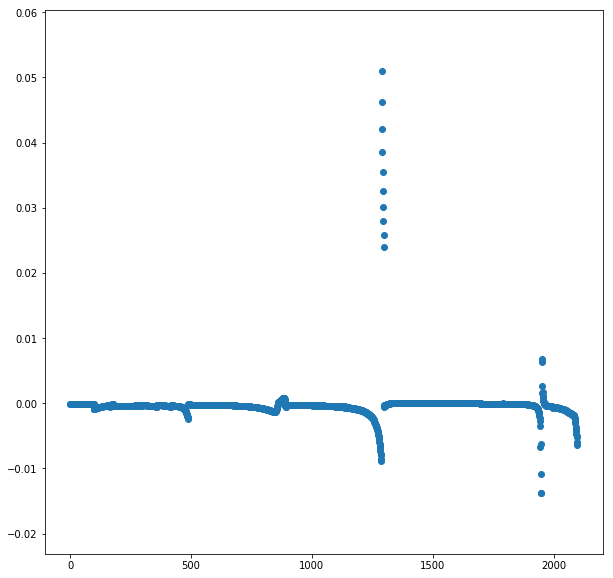

In [346]:
def der(x,y):
    ders = []
    for i in range(len(x)-1):
        ders.append((y[i+1]-y[i])/(x[i+1]+x[i]))
    return np.asarray(ders)

print(np.where(der(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG'])==der(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG'])[400:600].min()))

# def jump(x,y):
#     jumps = []
#     for i in range(len(x)-1):
#         jumps.append(np.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2))
#     return jumps

plt.figure(figsize=[10,10])
plt.scatter(range(len(tbasti[rgbage]['LOGT'])-1),der(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG']))
# plt.xlim(1000,2000)
# plt.ylim(-0.002,0.006)
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(range(len(tbasti[rgbage]['LOGT'])-1),jump(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG']))
# plt.show()

In [375]:
##############################
### Import statsmodels.api ###
##############################

import statsmodels.api as sm 

####################
### Prepare Data ###
####################

'''parameters: logTe, Hmag, [FE/H], logg'''\

# logage = np.array(tbasti[rgb]['LOGAGE'].data)

# J = np.array(tbasti[rgb]['JMAG'].data)
# K = np.array(tbasti[rgb]['KMAG'].data)

# logteff = np.array(tbasti[rgb]['LOGT'].data)
# H = np.array(tbasti[rgb]['HMAG'].data)
# feh = np.array(tbasti[rgb]['FEH'])
# logg = np.array(tbasti[rgb]['LOGG'].data)

logage = np.array(trgb['LOGAGE'].data)

J = np.array(trgb['JMAG'].data)
K = np.array(trgb['KMAG'].data)

logteff = np.array(trgb['LOGT'].data)
H = np.array(trgb['HMAG'].data)
feh = np.array(trgb['FEH'])
logg = np.array(trgb['LOGG'].data)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.051e+08
Date:                Fri, 05 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:20:32   Log-Likelihood:             1.8080e+06
No. Observations:              651584   AIC:                        -3.616e+06
Df Residuals:                  651572   BIC:                        -3.616e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        432.8312      1.015    426.399      0.0

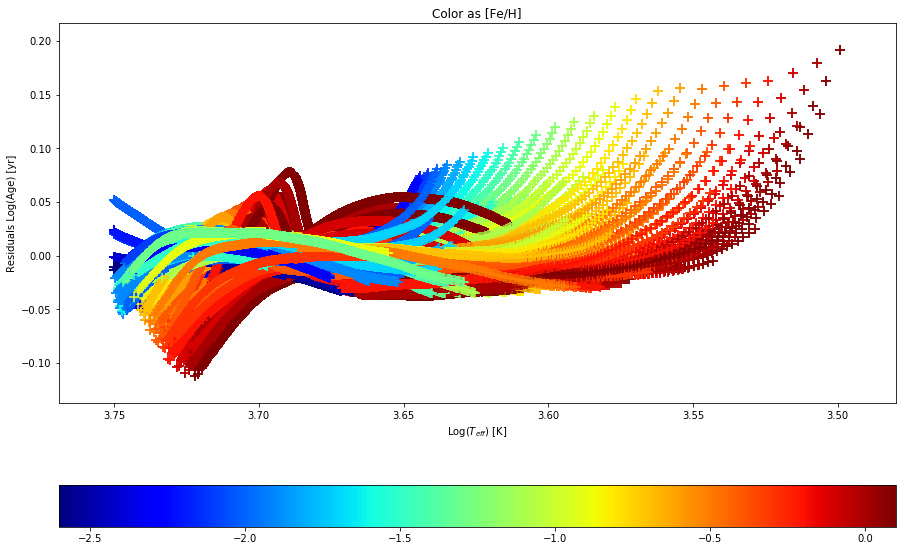

0.008429361079149267


In [459]:
#################################
### Fit PARSEC model to BaSTI ###
#################################

pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,feh),\
                   np.multiply(logteff,logg),np.multiply(K,logg),\
                   logteff**2,K**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.colorbar(orientation='horizontal')
plt.gca().invert_xaxis()
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad(residual))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.104e+08
Date:                Thu, 04 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:45:10   Log-Likelihood:             1.8785e+06
No. Observations:              651584   AIC:                        -3.757e+06
Df Residuals:                  651570   BIC:                        -3.757e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        989.4140      1.895    522.233      0.0

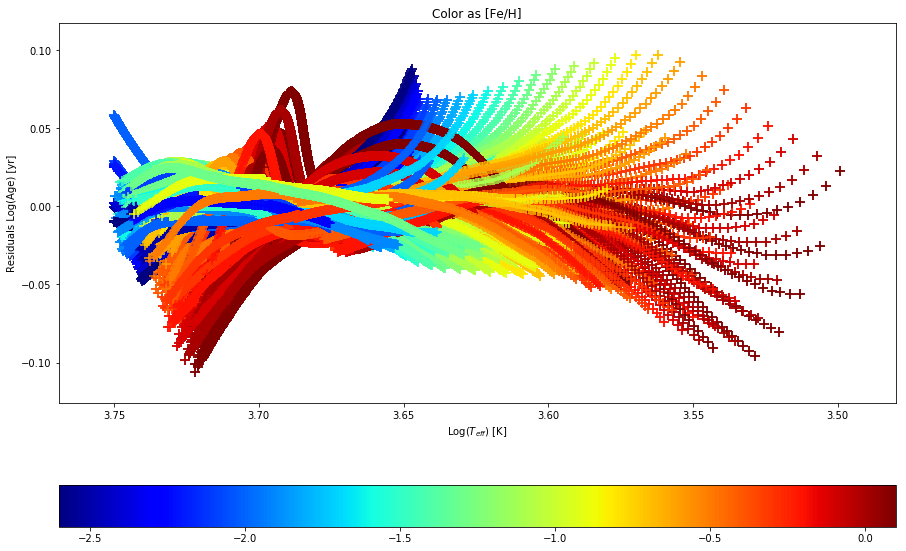

0.006948074525944925


In [449]:
###################
###  ###
###################

pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,feh),\
                  np.multiply(logteff,logg),np.multiply(K,logg),np.multiply(logteff**2,feh),\
                  np.multiply(logteff**2,K),logteff**2,K**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad(residual))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.928e+07
Date:                Fri, 05 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:12:46   Log-Likelihood:             1.8905e+06
No. Observations:              651584   AIC:                        -3.781e+06
Df Residuals:                  651568   BIC:                        -3.781e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5234.3348     33.836    154.699      0.0

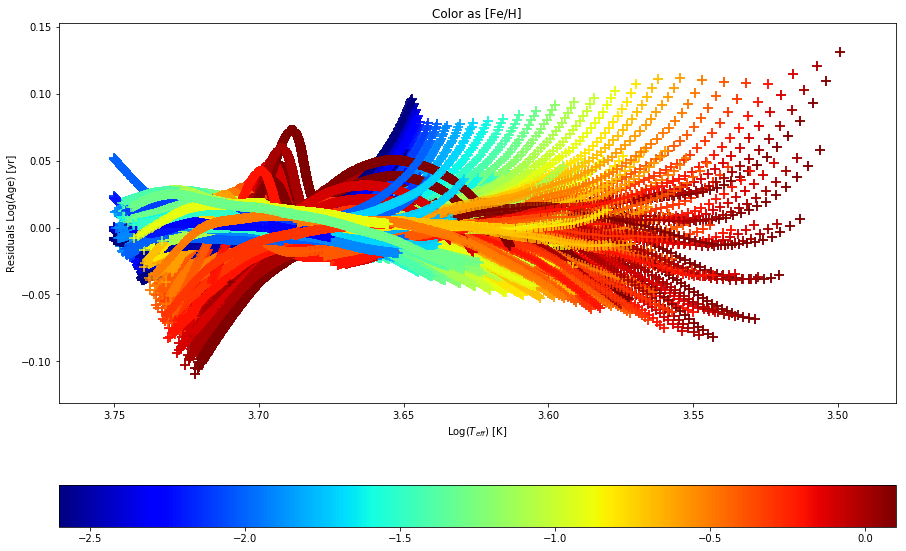

0.006654861995348149


In [457]:
'''Try something'''

#pmodl = np.array([logteff,K,feh,logg,K**2,feh**2,logteff**3]).T

#pmodl = np.array([logteff,K,feh,logg,logteff**2,K**2,feh**2,logg**2,K**3,feh**3,logg**3]).T

pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,feh),np.multiply(logteff,logg),\
                 np.multiply(K,logg),np.multiply(logteff**2,feh),np.multiply(logteff**2,K),logteff**2,K**2,\
                 logg**2,logteff**3,logg**3]).T


pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad(residual))